# Performance of state space sample of all the possible TensorFlow==2.4.0 on ubi8 python3.8

The purpose of this notebook is to have a reusable notebook that can be customized depending on the performance analysis that can be performed based on [Amun Service](https://github.com/thoth-station/amun-api) and using [Performance Indicators](https://github.com/thoth-station/performance).

## Amun Inspections inputs

The description of the dataset can be found [here](https://github.com/thoth-station/dependency-monkey-zoo/tree/master/tensorflow/inspection-2021-02-09).

**Software stacks and native dependencies**

  * `PyPI TensorFlow` - `tensorflow==2.4.0` available on PyPI index

**OS images**

  * `rhel-8` 

**Python Interpreters**

  * `3.8` 


**Hardware**


### Performance indicators
Performance Indicators (PI) used for performance analysis:

  * [matrix multiplication](https://github.com/thoth-station/performance/blob/master/tensorflow/matmul.py)

Each performance indicator was run `1` per inspection run (`batch size == 1`), performance indicators reported median of inspections to be further compared.

## Dataset content

Inspection specification, build logs, job logs, hardware information of the node where the performance indicator was run and the actual inspection job result.

No buildtime/runtime errors spotted with the tested stack.


# Analysis

Results of performance are shown in terms of Elapsed time [ms].

The analysis performed in this notebook are defined as:

- Randomly sampled state space of all the possible TensorFlow==2.4.0 software stacks for UBI 8 Python 3.8 to identify errors and new possible recommendations.


## Assign environment variables and import libraries

In [1]:
%env THOTH_DEPLOYMENT_NAME     ocp4-stage
%env THOTH_CEPH_HOST           https://s3.upshift.redhat.com/
%env THOTH_CEPH_BUCKET         thoth
%env THOTH_CEPH_BUCKET_PREFIX  data

env: THOTH_DEPLOYMENT_NAME=ocp4-stage
env: THOTH_CEPH_HOST=https://s3.upshift.redhat.com/
env: THOTH_CEPH_BUCKET=thoth
env: THOTH_CEPH_BUCKET_PREFIX=data


In [2]:
from thoth.report_processing.components.inspection import AmunInspections
from thoth.report_processing.components.inspection import AmunInspectionsSummary
from thoth.report_processing.components.inspection import AmunInspectionsStatistics

inspection = AmunInspections()
inspection_runs_summary = AmunInspectionsSummary()
inspection_statistics = AmunInspectionsStatistics()

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1500)
pd.options.plotting.backend = "matplotlib"  # Convert to matplotlib

### Extract dataset if data are not retrieved from Ceph

In [ ]:
FILE_NAME = "thoth-performance-dataset-inspectionsAnalysis20210209.zip"
from thoth.report_processing.utils import extract_zip_file
extract_zip_file(FILE_NAME)

In [3]:
## Download inspections ids

import requests

url = 'https://raw.githubusercontent.com/thoth-station/dependency-monkey-zoo/master/tensorflow/inspection-2021-02-09/scheduled.txt'
r = requests.get(url)
inspection_ids_list = r.content.decode().split("\n")
print(len(inspection_ids_list))

801


## Retrieve and process data

### from Ceph

In [5]:
# inspection_runs = inspection.aggregate_thoth_inspections_results(
#     inspection_ids_list=inspection_ids_list,
# )

### from local path

In [ ]:
from pathlib import Path

current_path = Path.cwd()

inspection_runs = inspection.aggregate_thoth_inspections_results(
    is_local=True,
    repo_path=current_path.joinpath("inspectionsAnalysis20210209")
)

In [ ]:
processed_inspection_runs, failed_inspection_runs = inspection.process_inspection_runs(
    inspection_runs,
)

In [ ]:
inspections_df = inspection.create_inspections_dataframe(
    processed_inspection_runs=processed_inspection_runs,
    include_statistics=True
)

In [7]:
inspections_df.head()

,end_datetime,exit_code,hostname,script_sha256,start_datetime,stderr,inspection_document_id,identifier,specification_base,batch_size,hwinfo__cpu_features__flags,hwinfo__cpu_features__hz_actual,hwinfo__cpu_features__hz_actual_raw,hwinfo__cpu_features__hz_advertised,hwinfo__cpu_features__hz_advertised_raw,hwinfo__cpu_features__l1_data_cache_size,hwinfo__cpu_features__l1_instruction_cache_size,hwinfo__cpu_features__l2_cache_size,hwinfo__cpu_features__l3_cache_size,hwinfo__cpu_info__arch,hwinfo__cpu_info__arch_string_raw,hwinfo__cpu_info__bits,hwinfo__cpu_info__brand_raw,hwinfo__cpu_info__count,hwinfo__cpu_info__cpuinfo_version,hwinfo__cpu_info__cpuinfo_version_string,hwinfo__cpu_info__family,hwinfo__cpu_info__hz_actual_friendly,hwinfo__cpu_info__hz_advertised_friendly,hwinfo__cpu_info__l2_cache_associativity,hwinfo__cpu_info__l2_cache_line_size,hwinfo__cpu_info__model,hwinfo__cpu_info__stepping,hwinfo__cpu_info__vendor_id_raw,hwinfo__cpu_type__has_3dnow,hwinfo__cpu_type__has_3dnowext,hwinfo__cpu_type__has_Altivec,hwinfo__cpu_type__has_f00f_bug,hwinfo__cpu_type__has_fdiv_bug,hwinfo__cpu_type__has_mmx,hwinfo__cpu_type__has_sse,hwinfo__cpu_type__has_sse2,hwinfo__cpu_type__has_sse3,hwinfo__cpu_type__has_ssse3,hwinfo__cpu_type__is_32bit,hwinfo__cpu_type__is_64bit,hwinfo__cpu_type__is_AMD,hwinfo__cpu_type__is_AMD64,hwinfo__cpu_type__is_Alpha,hwinfo__cpu_type__is_Athlon64,hwinfo__cpu_type__is_AthlonHX,hwinfo__cpu_type__is_AthlonK6,hwinfo__cpu_type__is_AthlonK6_2,hwinfo__cpu_type__is_AthlonK6_3,hwinfo__cpu_type__is_AthlonK7,hwinfo__cpu_type__is_AthlonMP,hwinfo__cpu_type__is_Celeron,hwinfo__cpu_type__is_Core2,hwinfo__cpu_type__is_EV4,hwinfo__cpu_type__is_EV5,hwinfo__cpu_type__is_EV56,hwinfo__cpu_type__is_Hammer,hwinfo__cpu_type__is_Intel,hwinfo__cpu_type__is_Itanium,hwinfo__cpu_type__is_Nocona,hwinfo__cpu_type__is_Opteron,hwinfo__cpu_type__is_PCA56,hwinfo__cpu_type__is_Pentium,hwinfo__cpu_type__is_PentiumII,hwinfo__cpu_type__is_PentiumIII,hwinfo__cpu_type__is_PentiumIV,hwinfo__cpu_type__is_PentiumM,hwinfo__cpu_type__is_PentiumMMX,hwinfo__cpu_type__is_PentiumPro,hwinfo__cpu_type__is_Power,hwinfo__cpu_type__is_Power7,hwinfo__cpu_type__is_Power8,hwinfo__cpu_type__is_Power9,hwinfo__cpu_type__is_Prescott,hwinfo__cpu_type__is_XEON,hwinfo__cpu_type__is_Xeon,hwinfo__cpu_type__is_i386,hwinfo__cpu_type__is_i486,hwinfo__cpu_type__is_i586,hwinfo__cpu_type__is_i686,hwinfo__cpu_type__is_singleCPU,hwinfo__cpu_type__nbits,hwinfo__cpu_type__ncpus,hwinfo__cpu_type__not_impl,hwinfo__cpu_type__try_call,hwinfo__platform__architecture,hwinfo__platform__machine,hwinfo__platform__node,hwinfo__platform__platform,hwinfo__platform__processor,hwinfo__platform__release,hwinfo__platform__version,os_release__ansi_color,os_release__bug_report_url,os_release__cpe_name,os_release__home_url,os_release__id,os_release__id_like,os_release__name,os_release__platform_id,os_release__pretty_name,os_release__redhat_bugzilla_product,os_release__redhat_bugzilla_product_version,os_release__redhat_support_product,os_release__redhat_support_product_version,os_release__version,os_release__version_id,runtime_environment__cuda_version,runtime_environment__hardware__cpu_family,runtime_environment__hardware__cpu_model,runtime_environment__operating_system__name,runtime_environment__operating_system__version,runtime_environment__python_version,stdout__@parameters__device,stdout__@parameters__dtype,stdout__@parameters__matrix_size,stdout__@parameters__mini_batch,stdout__@parameters__reps,stdout__@result__elapsed,stdout__@result__rate,stdout__component,stdout__name,stdout__tensorflow_aicoe_buildinfo,stdout__tensorflow_upstream_buildinfo__cpu_compiler,stdout__tensorflow_upstream_buildinfo__cuda_compute_capabilities,stdout__tensorflow_upstream_buildinfo__cuda_version,stdout__tensorflow_upstream_buildinfo__cudnn_version,stdout__tensorflow_upstream_buildinfo__is_cuda_build,stdout__tensorflow_upstream_buildinfo__is_rocm_build,usage__ru_idrss,usage__ru_inblock,usage__ru_isrss,usage__ru_ixrss,usage__

# Inspections summary report

In [13]:
report_results, _ = inspection_runs_summary.produce_summary_report(inspections_df=inspections_df)

## Hardware

In [102]:
report_results["hardware"]['platform'].head()

,hwinfo__platform__architecture,hwinfo__platform__machine,hwinfo__platform__node,hwinfo__platform__platform,hwinfo__platform__processor,hwinfo__platform__release,hwinfo__platform__version
0,nan,x86_64,inspection-tf-dm-tf24-23d24403-1441347026,Linux-4.18.0-193.41.1.el8_2.x86_64-x86_64-with...,x86_64,4.18.0-193.41.1.el8_2.x86_64,#1 SMP Wed Jan 13 11:33:33 EST 2021
1,nan,x86_64,inspection-tf-dm-tf24-12e32068-498785683,Linux-4.18.0-193.41.1.el8_2.x86_64-x86_64-with...,x86_64,4.18.0-193.41.1.el8_2.x86_64,#1 SMP Wed Jan 13 11:33:33 EST 2021
2,nan,x86_64,inspection-tf-dm-tf24-70d5c9ce-3280793054,Linux-4.18.0-193.41.1.el8_2.x86_64-x86_64-with...,x86_64,4.18.0-193.41.1.el8_2.x86_64,#1 SMP Wed Jan 13 11:33:33 EST 2021
3,nan,x86_64,inspection-tf-dm-tf24-b4cb2912-4234197245,Linux-4.18.0-193.41.1.el8_2.x86_64-x86_64-with...,x86_64,4.18.0-193.41.1.el8_2.x86_64,#1 SMP Wed Jan 13 11:33:33 EST 2021
4,nan,x86_64,inspection-tf-dm-tf24-ab55ca35-2768087445,Linux-4.18.0-193.41.1.el8_2.x86_64-x86_64-with...,x86_64,4.18.0-193.41.1.el8_2.x86_64,#1 SMP Wed Jan 13 11:33:33 EST 2021


In [15]:
report_results["hardware"]['processor']

,hwinfo__cpu_type__has_3dnow,hwinfo__cpu_type__has_3dnowext,hwinfo__cpu_type__has_Altivec,hwinfo__cpu_type__has_f00f_bug,hwinfo__cpu_type__has_fdiv_bug,hwinfo__cpu_type__has_mmx,hwinfo__cpu_type__has_sse,hwinfo__cpu_type__has_sse2,hwinfo__cpu_type__has_sse3,hwinfo__cpu_type__has_ssse3,hwinfo__cpu_type__is_32bit,hwinfo__cpu_type__is_64bit,hwinfo__cpu_type__is_AMD,hwinfo__cpu_type__is_AMD64,hwinfo__cpu_type__is_Alpha,hwinfo__cpu_type__is_Athlon64,hwinfo__cpu_type__is_AthlonHX,hwinfo__cpu_type__is_AthlonK6,hwinfo__cpu_type__is_AthlonK6_2,hwinfo__cpu_type__is_AthlonK6_3,hwinfo__cpu_type__is_AthlonK7,hwinfo__cpu_type__is_AthlonMP,hwinfo__cpu_type__is_Celeron,hwinfo__cpu_type__is_Core2,hwinfo__cpu_type__is_EV4,hwinfo__cpu_type__is_EV5,hwinfo__cpu_type__is_EV56,hwinfo__cpu_type__is_Hammer,hwinfo__cpu_type__is_Intel,hwinfo__cpu_type__is_Itanium,hwinfo__cpu_type__is_Nocona,hwinfo__cpu_type__is_Opteron,hwinfo__cpu_type__is_PCA56,hwinfo__cpu_type__is_Pentium,hwinfo__cpu_type__is_PentiumII,hwinfo__cpu_type__is_PentiumIII,hwinfo__cpu_type__is_PentiumIV,hwinfo__cpu_type__is_PentiumM,hwinfo__cpu_type__is_PentiumMMX,hwinfo__cpu_type__is_PentiumPro,hwinfo__cpu_type__is_Power,hwinfo__cpu_type__is_Power7,hwinfo__cpu_type__is_Power8,hwinfo__cpu_type__is_Power9,hwinfo__cpu_type__is_Prescott,hwinfo__cpu_type__is_XEON,hwinfo__cpu_type__is_Xeon,hwinfo__cpu_type__is_i386,hwinfo__cpu_type__is_i486,hwinfo__cpu_type__is_i586,hwinfo__cpu_type__is_i686,hwinfo__cpu_type__is_singleCPU
0,False,False,nan,nan,nan,True,True,True,True,True,False,True,False,False,nan,False,False,False,False,False,False,False,False,False,nan,nan,nan,False,True,nan,False,False,nan,False,False,False,False,False,False,False,nan,nan,nan,nan,False,True,True,nan,nan,False,True,False


In [16]:
report_results["hardware"]['flags']

,flag__3dnowprefetch,flag__abm,flag__adx,flag__aes,flag__apic,flag__arat,flag__arch_capabilities,flag__avx,flag__avx2,flag__avx512bw,flag__avx512cd,flag__avx512dq,flag__avx512f,flag__avx512vl,flag__bmi1,flag__bmi2,flag__clflush,flag__clflushopt,flag__clwb,flag__cmov,flag__constant_tsc,flag__cpuid,flag__cpuid_fault,flag__cx16,flag__cx8,flag__de,flag__ept,flag__erms,flag__f16c,flag__flexpriority,flag__fma,flag__fpu,flag__fsgsbase,flag__fxsr,flag__hle,flag__hypervisor,flag__ibpb,flag__ibrs,flag__invpcid,flag__invpcid_single,flag__lahf_lm,flag__lm,flag__mca,flag__mce,flag__md_clear,flag__mmx,flag__movbe,flag__mpx,flag__msr,flag__mtrr,flag__nopl,flag__nx,flag__ospke,flag__osxsave,flag__pae,flag__pat,flag__pcid,flag__pclmulqdq,flag__pdpe1gb,flag__pge,flag__pku,flag__pni,flag__popcnt,flag__pse,flag__pse36,flag__pti,flag__rdrand,flag__rdrnd,flag__rdseed,flag__rdtscp,flag__rep_good,flag__rtm,flag__sep,flag__smap,flag__smep,flag__ss,flag__ssbd,flag__sse,flag__sse2,flag__sse4_1,flag__sse4_2,flag__ssse3,flag__stibp,flag__syscall,flag__tpr_shadow,flag__tsc,flag__tsc_adjust,flag__tsc_deadline_timer,flag__tsc_known_freq,flag__tscdeadline,flag__umip,flag__vme,flag__vmx,flag__vnmi,flag__vpid,flag__x2apic,flag__xgetbv1,flag__xsave,flag__xsavec,flag__xsaveopt,flag__xsaves,flag__xtopology
0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,nan,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,nan,True,True,True,True,True,True,True,True,True,nan,True


In [111]:
report_results["hardware"]['ncpus']

,hwinfo__cpu_type__ncpus
0,64


In [18]:
report_results["hardware"]['info']

,hwinfo__cpu_info__brand_raw,runtime_environment__cuda_version,runtime_environment__hardware__cpu_family,runtime_environment__hardware__cpu_model
0,"Intel Xeon Processor (Skylake, IBRS)",nan,6,85


## Operating System

In [19]:
report_results["base_image"]['base_image']

,specification_base,os_release__name,os_release__version,os_release__version_id
0,quay.io/thoth-station/s2i-thoth-ubi8-py38:v0.24.2,Red Hat Enterprise Linux,8.3 (Ootpa),8.3


In [20]:
report_results["base_image"]['number_cpus_run']

,run__requests__cpu
0,1


## Performance Indicator

In [21]:
report_results["pi"]['pi']

,script_sha256,batch_size,stdout__@parameters__device,stdout__@parameters__dtype,stdout__@parameters__matrix_size,stdout__@parameters__mini_batch,stdout__@parameters__reps,stdout__component,stdout__name
0,1ce2ae4cf0da06c8c55b99be8beb31cae7c6801bb99664...,1,cpu,float32,512,40,50,tensorflow,PiMatmul


## Software Stack

In [101]:
report_results["software_stack"]['requirements_locked'].head()

,requirements_locked___meta__sources,requirements_locked___meta__requires__python_version,requirements_locked___meta__hash__sha256,requirements_locked___meta__pipfile-spec,requirements_locked__default__tensorflow__version,requirements_locked__default__tensorflow__index,requirements_locked__default__typing-extensions__version,requirements_locked__default__typing-extensions__index,requirements_locked__default__wrapt__version,requirements_locked__default__wrapt__index,requirements_locked__default__grpcio__version,requirements_locked__default__grpcio__index,requirements_locked__default__wheel__version,requirements_locked__default__wheel__index,requirements_locked__default__keras-preprocessing__version,requirements_locked__default__keras-preprocessing__index,requirements_locked__default__opt-einsum__version,requirements_locked__default__opt-einsum__index,requirements_locked__default__numpy__version,requirements_locked__default__numpy__index,requirements_locked__default__tensorflow-estimator__version,requirements_locked__default__tensorflow-estimator__index,requirements_locked__default__gast__version,requirements_locked__default__gast__index,requirements_locked__default__flatbuffers__version,requirements_locked__default__flatbuffers__index,requirements_locked__default__absl-py__version,requirements_locked__default__absl-py__index,requirements_locked__default__h5py__version,requirements_locked__default__h5py__index,requirements_locked__default__astunparse__version,requirements_locked__default__astunparse__index,requirements_locked__default__termcolor__version,requirements_locked__default__termcolor__index,requirements_locked__default__protobuf__version,requirements_locked__default__protobuf__index,requirements_locked__default__six__version,requirements_locked__default__six__index,requirements_locked__default__setuptools__version,requirements_locked__default__setuptools__index,requirements_locked__default__tensorboard__version,requirements_locked__default__tensorboard__index,requirements_locked__default__google-pasta__version,requirements_locked__default__google-pasta__index,requirements_locked__default__werkzeug__version,requirements_locked__default__werkzeug__index,requirements_locked__default__requests__version,requirements_locked__default__requests__index,requirements_locked__default__google-auth__version,requirements_locked__default__google-auth__index,requirements_locked__default__pyasn1-modules__version,requirements_locked__default__pyasn1-modules__index,requirements_locked__default__tensorboard-plugin-wit__version,requirements_locked__default__tensorboard-plugin-wit__index,requirements_locked__default__pyasn1__version,requirements_locked__default__pyasn1__index,requirements_locked__default__rsa__version,requirements_locked__default__rsa__index,requirements_locked__default__idna__version,requirements_locked__default__idna__index,requirements_locked__default__urllib3__version,requirements_locked__default__urllib3__index,requirements_locked__default__cachetools__version,requirements_locked__default__cachetools__index,requirements_locked__default__markdown__version,requirements_locked__default__markdown__index,requirements_locked__default__certifi__version,requirements_locked__default__certifi__index,requirements_locked__default__google-auth-oauthlib__version,requirements_locked__default__google-auth-oauthlib__index,requirements_locked__default__chardet__version,requirements_locked__default__chardet__index,requirements_locked__default__requests-oauthlib__version,requirements_locked__default__requests-oauthlib__index,requirements_locked__default__oauthlib__version,requirements_locked__default__oauthlib__index
0,nan,3.8,11ae15263f6d0a834ab2b568343195bdd01337d61b784d...,6,==2.4.0,pypi-org-simple,==3.7.4.3,pypi-org-simple,==1.12.1,pypi-org-simple,==1.32.0,pypi-org-simple,==0.35.1,pypi-org-simple,==1.1.2,pypi-org-simple,==3.3.0,pypi-org-simple,==1.19.4,pypi-org-simple,==2.4.0,pypi-org-simple,==0.3.3,pypi-org-simple,==1.12,pypi-org-simp

In [8]:
python_packages_dataframe, python_packages_versions, versions_total_dataframe = inspection.create_python_package_df(inspections_df=inspections_df)
python_packages_dataframe.head()

,tensorflow,typing-extensions,wrapt,grpcio,wheel,keras-preprocessing,opt-einsum,numpy,tensorflow-estimator,gast,flatbuffers,absl-py,h5py,astunparse,termcolor,protobuf,six,setuptools,tensorboard,google-pasta,werkzeug,requests,google-auth,tensorboard-plugin-wit,markdown,certifi,google-auth-oauthlib,requests-oauthlib,chardet,urllib3,oauthlib,cachetools,idna,rsa,pyasn1-modules,pyasn1
0,tensorflow-2.4.0-pypi-org-simple,typing-extensions-3.7.4.3-pypi-org-simple,wrapt-1.12.1-pypi-org-simple,grpcio-1.32.0-pypi-org-simple,wheel-0.35.1-pypi-org-simple,keras-preprocessing-1.1.2-pypi-org-simple,opt-einsum-3.3.0-pypi-org-simple,numpy-1.19.4-pypi-org-simple,tensorflow-estimator-2.4.0-pypi-org-simple,gast-0.3.3-pypi-org-simple,flatbuffers-1.12-pypi-org-simple,absl-py-0.11.0-pypi-org-simple,h5py-2.10.0-pypi-org-simple,astunparse-1.6.3-pypi-org-simple,termcolor-1.1.0-pypi-org-simple,protobuf-3.12.1-pypi-org-simple,six-1.15.0-pypi-org-simple,setuptools-46.1.2-pypi-org-simple,tensorboard-2.4.0-pypi-org-simple,google-pasta-0.2.0-pypi-org-simple,werkzeug-0.15.2-pypi-org-simple,requests-2.24.0-pypi-org-simple,google-auth-1.11.0-pypi-org-simple,tensorboard-plugin-wit-1.6.0.post2-pypi-org-si...,markdown-2.6.8-pypi-org-simple,certifi-2017.7.27-pypi-org-simple,google-auth-oauthlib-0.4.1-pypi-org-simple,requests-oauthlib-1.1.0-pypi-org-simple,chardet-3.0.4-pypi-org-simple,urllib3-1.24.1-pypi-org-simple,oauthlib-2.1.0-pypi-org-simple,cachetools-4.1.1-pypi-org-simple,idna-2.6-pypi-org-simple,rsa-3.2.2-pypi-org-simple,pyasn1-modules-0.2.1-pypi-org-simple,pyasn1-0.4.6-pypi-org-simple
1,tensorflow-2.4.0-pypi-org-simple,typing-extensions-3.7.4.3-pypi-org-simple,wrapt-1.12.1-pypi-org-simple,grpcio-1.32.0-pypi-org-simple,wheel-0.35.1-pypi-org-simple,keras-preprocessing-1.1.2-pypi-org-simple,opt-einsum-3.3.0-pypi-org-simple,numpy-1.19.4-pypi-org-simple,tensorflow-estimator-2.4.0-pypi-org-simple,gast-0.3.3-pypi-org-simple,flatbuffers-1.12-pypi-org-simple,absl-py-0.11.0-pypi-org-simple,h5py-2.10.0-pypi-org-simple,astunparse-1.6.3-pypi-org-simple,termcolor-1.1.0-pypi-org-simple,protobuf-3.12.1-pypi-org-simple,six-1.15.0-pypi-org-simple,setuptools-46.1.2-pypi-org-simple,tensorboard-2.4.0-pypi-org-simple,google-pasta-0.2.0-pypi-org-simple,werkzeug-0.15.2-pypi-org-simple,requests-2.24.0-pypi-org-simple,google-auth-1.11.0-pypi-org-simple,tensorboard-plugin-wit-1.6.0.post2-pypi-org-si...,markdown-2.6.8-pypi-org-simple,certifi-2017.7.27-pypi-org-simple,google-auth-oauthlib-0.4.1-pypi-org-simple,requests-oauthlib-1.1.0-pypi-org-simple,chardet-3.0.3-pypi-org-simple,urllib3-1.24.2-pypi-org-simple,oauthlib-2.1.0-pypi-org-simple,cachetools-3.1.1-pypi-org-simple,idna-2.9-pypi-org-simple,rsa-3.2.2-pypi-org-simple,pyasn1-modules-0.2.3-pypi-org-simple,pyasn1-0.4.8-pypi-org-simple
2,tensorflow-2.4.0-pypi-org-simple,typing-extensions-3.7.4.3-pypi-org-simple,wrapt-1.12.1-pypi-org-simple,grpcio-1.32.0-pypi-org-simple,wheel-0.35.1-pypi-org-simple,keras-preprocessing-1.1.2-pypi-org-simple,opt-einsum-3.3.0-pypi-org-simple,numpy-1.19.4-pypi-org-simple,tensorflow-estimator-2.4.0-pypi-org-simple,gast-0.3.3-pypi-org-simple,flatbuffers-1.12-pypi-org-simple,absl-py-0.11.0-pypi-org-simple,h5py-2.10.0-pypi-org-simple,astunparse-1.6.3-pypi-org-simple,termcolor-1.1.0-pypi-org-simple,protobuf-3.12.1-pypi-org-simple,six-1.15.0-pypi-org-simple,setuptools-46.1.2-pypi-org-simple,tensorboard-2.4.0-pypi-org-simple,google-pasta-0.2.0-pypi-org-simple,werkzeug-0.15.2-pypi-org-simple,requests-2.24.0-pypi-org-simple,google-auth-1.11.0-pypi-org-simple,tensorboard-plugin-wit-1.6.0.post3-pypi-org-si...,markdown-3.3.1-pypi-org-simple,certifi-2017.7.27.1-pypi-org-simple,google-auth-oauthlib-0.4.2-pypi-org-simple,requests-oauthlib-1.3.0-pypi-org-simple,chardet-3.0.4-pypi-org-simple,urllib3-1.25.9-pypi-org-simple,oauthlib-3.0.1-pypi-org-simple,cachetools-4.1.0-pypi-org-simple,idna-2.7-pypi-org-simple,rsa-3.2.2-pypi-org-simple,pyasn1-modules-0.2.6-pypi-org-simple,pyasn1-0.4.7-pypi-org-simple
3,tensorflow-2.4.0-pypi-

# Create final dataframe

In [30]:
final_dataframe = inspection.create_final_dataframe(
    inspections_df=inspections_df,
    include_statistics=True
)
final_dataframe.head()

,tensorflow,typing-extensions,wrapt,grpcio,wheel,keras-preprocessing,opt-einsum,numpy,tensorflow-estimator,gast,flatbuffers,absl-py,h5py,astunparse,termcolor,protobuf,six,setuptools,tensorboard,google-pasta,werkzeug,requests,google-auth,tensorboard-plugin-wit,markdown,certifi,google-auth-oauthlib,requests-oauthlib,chardet,urllib3,oauthlib,cachetools,idna,rsa,pyasn1-modules,pyasn1,packages_list,sws_string,sws_hash_id,sws_hash_id_encoded,solver,os_name,os_version,python_interpreter,solver_string,solver_hash_id,base,cpu_brand,cpu_family,cpu_model,number_cpus,cuda_version,pi_name,pi_component,pi_sha256,elapsed_time,rate,inspection_document_id,identifier,standardized_identifier,start_datetime,end_datetime,total_duration,inspection_batch,statistical_parameter,std,std_error,mean,median,q1,q3,iqr,min,max,cov,covm,skew
0,tensorflow-2.4.0-pypi-org-simple,typing-extensions-3.7.4.3-pypi-org-simple,wrapt-1.12.1-pypi-org-simple,grpcio-1.32.0-pypi-org-simple,wheel-0.35.1-pypi-org-simple,keras-preprocessing-1.1.2-pypi-org-simple,opt-einsum-3.3.0-pypi-org-simple,numpy-1.19.4-pypi-org-simple,tensorflow-estimator-2.4.0-pypi-org-simple,gast-0.3.3-pypi-org-simple,flatbuffers-1.12-pypi-org-simple,absl-py-0.11.0-pypi-org-simple,h5py-2.10.0-pypi-org-simple,astunparse-1.6.3-pypi-org-simple,termcolor-1.1.0-pypi-org-simple,protobuf-3.12.1-pypi-org-simple,six-1.15.0-pypi-org-simple,setuptools-46.1.2-pypi-org-simple,tensorboard-2.4.0-pypi-org-simple,google-pasta-0.2.0-pypi-org-simple,werkzeug-0.15.2-pypi-org-simple,requests-2.24.0-pypi-org-simple,google-auth-1.11.0-pypi-org-simple,tensorboard-plugin-wit-1.6.0.post2-pypi-org-si...,markdown-2.6.8-pypi-org-simple,certifi-2017.7.27-pypi-org-simple,google-auth-oauthlib-0.4.1-pypi-org-simple,requests-oauthlib-1.1.0-pypi-org-simple,chardet-3.0.4-pypi-org-simple,urllib3-1.24.1-pypi-org-simple,oauthlib-2.1.0-pypi-org-simple,cachetools-4.1.1-pypi-org-simple,idna-2.6-pypi-org-simple,rsa-3.2.2-pypi-org-simple,pyasn1-modules-0.2.1-pypi-org-simple,pyasn1-0.4.6-pypi-org-simple,"[tensorflow-2.4.0-pypi-org-simple, typing-exte...",tensorflow-2.4.0-pypi-org-simple<br>typing-ext...,55bbef8a8c6a58f4fd1d4f5aedb3b54c01f95ef2913dab...,239,"[rhel, 8.3, 3.8]",rhel,8.3,3.8,rhel-8.3-py38,7fcdc80258dd40908ed071a3542bb0c0ea6ad40831a072...,quay.io/thoth-station/s2i-thoth-ubi8-py38:v0.24.2,"Intel Xeon Processor (Skylake, IBRS)",6,85,1,None,PiMatmul,tensorflow,1ce2ae4cf0da06c8c55b99be8beb31cae7c6801bb99664...,496.340943,11.065863,inspection-tf-dm-tf24-4df33104,tf-dm-tf24,tf-dm-tf24,2021-02-09 15:54:31.051958,2021-02-09 15:54:58.212094,27,1,elapsed_time,NaN,NaN,496.340943,496.340943,496.340943,496.340943,0.0,496.340943,496.340943,NaN,0.0,NaN
1,tensorflow-2.4.0-pypi-org-simple,typing-extensions-3.7.4.3-pypi-org-simple,wrapt-1.12.1-pypi-org-simple,grpcio-1.32.0-pypi-org-simple,wheel-0.35.1-pypi-org-simple,keras-preprocessing-1.1.2-pypi-org-simple,opt-einsum-3.3.0-pypi-org-simple,numpy-1.19.4-pypi-org-simple,tensorflow-estimator-2.4.0-pypi-org-simple,gast-0.3.3-pypi-org-simple,flatbuffers-1.12-pypi-org-simple,absl-py-0.11.0-pypi-org-simple,h5py-2.10.0-pypi-org-simple,astunparse-1.6.3-pypi-org-simple,termcolor-1.1.0-pypi-org-simple,protobuf-3.12.1-pypi-org-simple,six-1.15.0-pypi-org-simple,setuptools-46.1.2-pypi-org-simple,tensorboard-2.4.0-pypi-org-simple,google-pasta-0.2.0-pypi-org-simple,werkzeug-0.15.2-pypi-org-simple,requests-2.24.0-pypi-org-simple,google-auth-1.11.0-pypi-org-simple,tensorboard-plugin-wit-1.6.0.post2-pypi-org-si...,markdown-2.6.8-pypi-org-simple,certifi-2017.7.27-pypi-org-simple,google-auth-oauthlib-0.4.1-pypi-org-simple,requests-oauthlib-1.1.0-pypi-org-simple,chardet-3.0.3-pypi-org-simple,urllib3-1.24.2-pypi-org-simple,oauthlib-2.1.0-pypi-org-simple,cachetools-3.1.1-pypi-org-simple,idna-2.9-pypi-org-simple,rsa-3.2.2-pypi-org-simple,pyasn1-modules-0.2.3-pypi-org-simple,pyasn1-0.4.8-pypi-org-simple,"[tensorflow-2.4.0-pypi-org-simple, typing-exte...",tensorflow-2.4.0-pypi-org-simple<br>typing-ext...,fac6b8a3f0eaa7033b05b7e

# Plots

## Performance plots

In [59]:
import os

from typing import List

import plotly.graph_objects as go

from typing import Optional, Dict
from thoth.python import Source
from plotly.subplots import make_subplots

from kaleido.scopes.plotly import PlotlyScope
scope = PlotlyScope()

python_package_index= "https://pypi.org/simple"
source = Source(python_package_index)

if not os.path.exists("images"):
    os.mkdir("images")

_PERFORMANCE_QUANTITY = ["elapsed_time", "rate"]

_PERFORMANCE_QUANTITY_MAP = {"elapsed_time": "Elapsed Time [ms]", "rate": "Rate [GFLOPS]"}


class AmunInspectionsVisualization:
    """Class of methods used to create statistics from Amun Inspections Runs."""

    @staticmethod
    def create_inspection_3d_plot(
        plot_df: pd.DataFrame,
        varying_package: str,
        title_plot: str,
        quantity: Optional[str] = 'elapsed_time',
        image_name: Optional[str] = None,
    ):
        """Create inspection performance parameters plot in 3D.

        :param plot_df: df for plots provided by `create_final_dataframe` or its subset.
        :param 
        """
        if quantity not in _PERFORMANCE_QUANTITY:
            _LOGGER.info(f"Only {_PERFORMANCE_QUANTITY} are accepted as quantity")
            return

        x_vector = [x[0] for x in plot_df[["solver_string"]].values]

        integer_y_encoded = [y[0] for y in plot_df[["sws_hash_id_encoded"]].values]

        z_vector = [z[0] for z in plot_df[[quantity]].values]
        trace1 = go.Scatter3d(
            x=x_vector,
            y=integer_y_encoded,
            z=z_vector,
            mode="markers",
            hovertext=[yc[0] for yc in plot_df[["sws_string"]].values],
            hoverinfo="text",
            marker=dict(
                size=8,
                color=z_vector,  # set color to an array/list of desired values
                colorscale="Viridis",  # choose a colorscale
                opacity=0.8,
                showscale=True,
            ),
        )

        data = [trace1]

        annotations = []
        c = 0

        for (x, y, z) in zip(x_vector, integer_y_encoded, z_vector):
            annotations.append(
                dict(
                    showarrow=False,
                    x=x,
                    y=y,
                    z=z,
                    text="".join(plot_df[varying_package].values[c]),
                    xanchor="left",
                    xshift=15,
                    opacity=0.7,
                )
            )
            c += 1

        margin = {"l": 200, "r": 100, "b": 100, "t": 100}

        layout = go.Layout(
            title=title_plot,
#             margin=margin,
            scene=dict(
                xaxis=dict(
                    title="Runtime Environment",
                    backgroundcolor="rgb(200, 200, 230)",
                    gridcolor="white",
                    showbackground=True,
                    zerolinecolor="white",
                    ),
                yaxis=dict(title="Software Stack ID",
                    backgroundcolor="rgb(230, 200,230)",
                    gridcolor="white",
                    showbackground=True,
                    zerolinecolor="white",
                    ),
                zaxis=dict(title=_PERFORMANCE_QUANTITY_MAP[quantity],
                    backgroundcolor="rgb(230, 230,200)",
                    gridcolor="white",
                    showbackground=True,
                    zerolinecolor="white"),
#                 annotations=annotations
            ),
            showlegend=True,
            legend=dict(orientation="h"),
        )
        fig = go.Figure(data=data, layout=layout)

        if not image_name:
            image_name = title_plot

        with open(f"images/{image_name}.png", "wb") as f:
            f.write(scope.transform(fig, format="png"))

        return fig
    
    
    @staticmethod
    def create_inspection_2d_plot(
        plot_df: pd.DataFrame,
        varying_package: str,
        title_plot: str,
        quantity: Optional[str] = 'elapsed_time',
        have_annotations: bool = False,
        image_name: Optional[str] = None,
    ):
        """Create inspection performance parameters plot in 2D.

        :param plot_df: df for plots provided by `create_final_dataframe` or its subset.
        """
        integer_y_encoded = [y[0] for y in plot_df[["sws_hash_id_encoded"]].values]

        data = []
        annotations = []
        colour_counter = 0
        distance: float = 0
        name_component = varying_package

        subset_df = plot_df[plot_df["pi_component"] == varying_package]
        z_vector = [z[0] for z in subset_df[[quantity]].values]

        trace = go.Scatter(
            x=integer_y_encoded,
            y=z_vector,
            mode="markers",
            hovertext=[y[0] for y in subset_df[["sws_string"]].values],
            hoverinfo="text",
            marker=dict(
                size=12,
                color=z_vector,  # set color to an array/list of desired values
#                 colorscale=color_scales[colour_counter],  # choose a colorscale
                opacity=0.8,
                showscale=True,
                colorbar={"x": 1 + distance},
            ),
            name=f"solver=={plot_df['solver_string'].unique()[0]}",
        )

        data.append(trace)
        colour_counter += 1
        distance += 0.2

        layout = go.Layout(
            title=title_plot,
            xaxis=dict(title="Software Stack ID integer encoded"),
            yaxis=dict(title=_PERFORMANCE_QUANTITY_MAP[quantity]),
            showlegend=True,
            legend=dict(orientation="h", y=-0.3, yanchor="top"),
        )
        fig = go.Figure(data=data, layout=layout)

        if not image_name:
            image_name = title_plot

        with open(f"images/{image_name}.png", "wb") as f:
            f.write(scope.transform(fig, format="png"))

        return fig
    
    @staticmethod
    def create_inspection_2d_plot_time(
        plot_df: pd.DataFrame,
        varying_package: str,
        title_plot: str,
        quantity: Optional[str] = 'elapsed_time',
        have_annotations: bool = False,
        image_name: Optional[str] = None,
    ):
        """Create inspection performance parameters plot in 2D.

        :param plot_df: df for plots provided by `create_final_dataframe` or its subset.
        """
        integer_y_encoded = [pd.to_datetime(y[0]) for y in plot_df[["start_datetime"]].values]
        data = []
        annotations = []
        colour_counter = 0
        distance: float = 0
        name_component = varying_package

        subset_df = plot_df[plot_df["pi_component"] == varying_package]
        z_vector = [z[0] for z in subset_df[[quantity]].values]

        trace = go.Scatter(
            x=integer_y_encoded,
            y=z_vector,
            mode="markers",
            hovertext=[y[0] for y in subset_df[["start_datetime"]].values],
            hoverinfo="text",
            marker=dict(
                size=12,
                color=z_vector,  # set color to an array/list of desired values
#                 colorscale=color_scales[colour_counter],  # choose a colorscale
                opacity=0.8,
                showscale=True,
                colorbar={"x": 1 + distance},
            ),
            name=f"solver=={plot_df['solver_string'].unique()[0]}",
        )

        data.append(trace)
        colour_counter += 1
        distance += 0.2

        layout = go.Layout(
            title=title_plot,
            xaxis=dict(title="Start time (datetime)"),
            yaxis=dict(title=_PERFORMANCE_QUANTITY_MAP[quantity]),
            showlegend=True,
            legend=dict(orientation="h", y=-0.3, yanchor="top"),
        )
        fig = go.Figure(data=data, layout=layout)

        if not image_name:
            image_name = title_plot

        with open(f"images/{image_name}.png", "wb") as f:
            f.write(scope.transform(fig, format="png"))

        return fig
    
    def create_packages_versions_2d_plot(
        plot_df: Dict[str, pd.DataFrame],
        title_plot: str,
        package_names: List[str],
        versions_total_df = pd.DataFrame,
        image_name: Optional[str] = None,
    ):
        """Create packages versions clusters plot in 2D.

        :param final_inspections_df: df for plots provided by `create_final_dataframe` or its subset.
        """        
        fig = make_subplots(rows=len(package_names), cols=1)
        
        ref_n = 1
        for package_name in package_names:
            
            package_versions = []

            try:
                versions = source.get_sorted_package_versions(package_name)

            except Exception as exc:
                print(str(exc))
            
            package_versions = sorted(versions_total_df[package_name].unique())

            if versions:
                
                actual_versions = [vv for vv in versions if str(vv) in package_versions]
                
                package_versions = actual_versions

            for i_ in package_versions:

                x_ = []
                y_ = []
                for name, df_ in plot_df.items():
                    y_unique = df_[package_name].unique() # packages

                    subset_df = df_[df_[package_name].str.contains(str(i_))]

                    x_cluster = [int(xx) for xx in subset_df[["sws_hash_id_encoded"]].values]  # SW ID
                    y_cluster = [name for n in subset_df[package_name].values]

                    x_ += x_cluster
                    y_ += y_cluster

                trace = go.Scatter(
                    x=x_,
                    y=y_,
                    mode="markers",
                    name=f"{package_name}-v{i_}",
                )
                
                fig.add_trace(
                    trace,
                    row=ref_n, col=1
                )
            
            layout = go.Layout(
                title=title_plot,
                xaxis=dict(title="Software Stack ID integer encoded"),
                yaxis=dict(title="clusters"),
                showlegend=True,
            )
        
            fig.update_layout(layout)
            
            ref_n += 1

        if not image_name:
            image_name = title_plot

        with open(f"images/{image_name}.png", "wb") as f:
            f.write(scope.transform(fig, format="png"))

        return fig

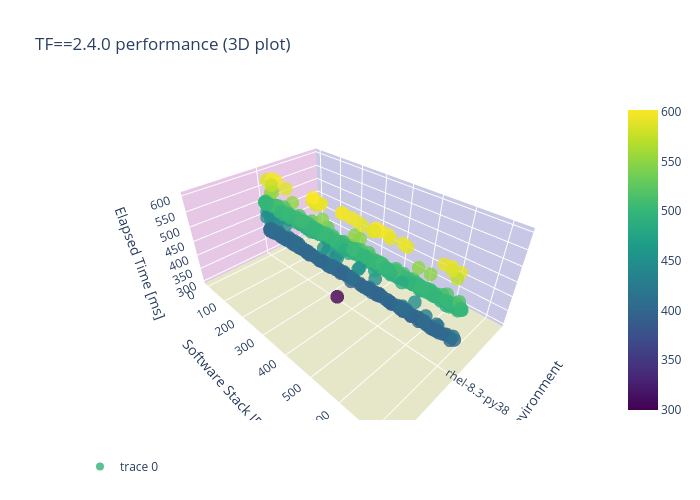

In [75]:
# Images are stored under /images
title_plot = "TF==2.4.0 performance (3D plot)"
fig = AmunInspectionsVisualization.create_inspection_3d_plot(plot_df=final_dataframe, quantity="elapsed_time", varying_package="tensorflow", title_plot=title_plot)
from IPython.display import Image
Image(filename=f'./images/{title_plot}.png') 

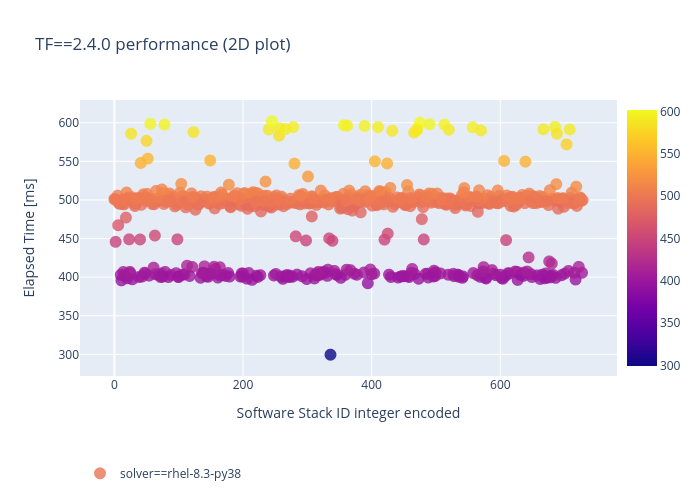

In [12]:
# Images are stored under /images
title_plot = "TF==2.4.0 performance (2D plot)"
fig = AmunInspectionsVisualization.create_inspection_2d_plot(plot_df=final_dataframe, varying_package="tensorflow", title_plot=title_plot)
from IPython.display import Image
Image(filename=f'./images/{title_plot}.png') 

2021-02-09 15:54:31.051958
2021-02-09


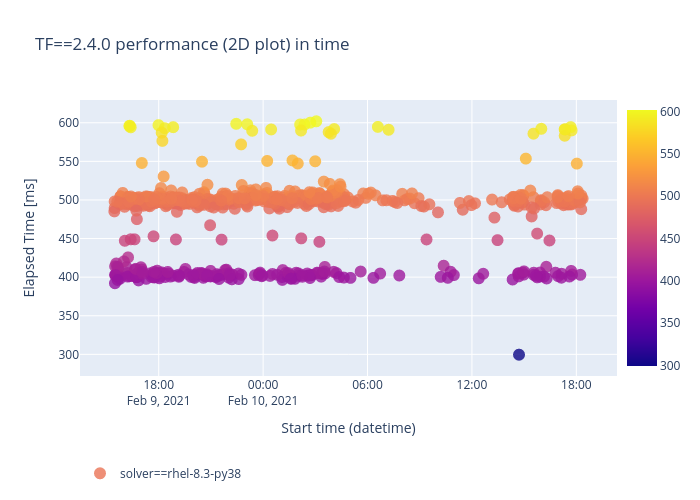

In [58]:
# Images are stored under /images
title_plot = "TF==2.4.0 performance (2D plot) in time"
fig = AmunInspectionsVisualization.create_inspection_2d_plot_time(plot_df=final_dataframe, varying_package="tensorflow", title_plot=title_plot)
from IPython.display import Image
Image(filename=f'./images/{title_plot}.png') 

Most performant stack

In [25]:
most_performant_stack = final_dataframe[final_dataframe['elapsed_time'] == final_dataframe.elapsed_time.min()]
packages = [p for p in most_performant_stack['packages_list'].values]

# check packages in that stack
for pkg in packages[0]:
    print(pkg)

tensorflow-2.4.0-pypi-org-simple
typing-extensions-3.7.4.3-pypi-org-simple
wrapt-1.12.1-pypi-org-simple
grpcio-1.32.0-pypi-org-simple
wheel-0.35.1-pypi-org-simple
keras-preprocessing-1.1.2-pypi-org-simple
opt-einsum-3.3.0-pypi-org-simple
numpy-1.19.4-pypi-org-simple
tensorflow-estimator-2.4.0-pypi-org-simple
gast-0.3.3-pypi-org-simple
flatbuffers-1.12-pypi-org-simple
absl-py-0.11.0-pypi-org-simple
h5py-2.10.0-pypi-org-simple
astunparse-1.6.3-pypi-org-simple
termcolor-1.1.0-pypi-org-simple
protobuf-3.12.1-pypi-org-simple
six-1.15.0-pypi-org-simple
setuptools-46.1.2-pypi-org-simple
tensorboard-2.4.0-pypi-org-simple
google-pasta-0.2.0-pypi-org-simple
werkzeug-0.15.2-pypi-org-simple
requests-2.24.0-pypi-org-simple
google-auth-1.11.0-pypi-org-simple
pyasn1-modules-0.2.7-pypi-org-simple
tensorboard-plugin-wit-1.6.0.post3-pypi-org-simple
pyasn1-0.4.8-pypi-org-simple
rsa-3.3-pypi-org-simple
idna-2.8-pypi-org-simple
urllib3-1.21.1-pypi-org-simple
cachetools-4.1.1-pypi-org-simple
markdown-3.1-py

Cluster the software stack to identify commonalities in the patterns identified in the plot

In [11]:
clusters = {
    "cluster 1": final_dataframe[final_dataframe["elapsed_time"] < 425],
    "cluster 2": final_dataframe[(final_dataframe["elapsed_time"] >= 425) & (final_dataframe["elapsed_time"] < 475)],
    "cluster 3": final_dataframe[(final_dataframe["elapsed_time"] >= 475) & (final_dataframe["elapsed_time"] < 525)],
    "cluster 4": final_dataframe[(final_dataframe["elapsed_time"] >= 525) & (final_dataframe["elapsed_time"] < 575)],
    "cluster 5": final_dataframe[(final_dataframe["elapsed_time"] >= 575)],
}

cluster_processing = {}

for name, df_ in clusters.items(): 
    if name not in cluster_processing.keys():
        cluster_processing[name] = {}

    for package in sorted([k for k in python_packages_versions.keys()]):
        n_cluster = 0
        versions = final_dataframe[package].unique()
        
        y_ = df_[package].values

        for y_u in versions:
            total_number = df_[df_[package] == y_u].shape[0]
            cluster_processing[name][y_u] = total_number

clusters_df = pd.DataFrame(cluster_processing).transpose()
clusters_df

,absl-py-0.11.0-pypi-org-simple,astunparse-1.6.3-pypi-org-simple,cachetools-4.1.1-pypi-org-simple,cachetools-3.1.1-pypi-org-simple,cachetools-4.1.0-pypi-org-simple,cachetools-4.2.0-pypi-org-simple,cachetools-3.0.0-pypi-org-simple,cachetools-3.1.0-pypi-org-simple,cachetools-4.0.0-pypi-org-simple,cachetools-2.0.1-pypi-org-simple,cachetools-2.0.0-pypi-org-simple,cachetools-2.1.0-pypi-org-simple,certifi-2017.7.27-pypi-org-simple,certifi-2017.7.27.1-pypi-org-simple,certifi-2018.4.16-pypi-org-simple,certifi-2018.10.15-pypi-org-simple,certifi-2018.8.24-pypi-org-simple,certifi-2018.8.13-pypi-org-simple,certifi-2019.11.28-pypi-org-simple,certifi-2018.11.29-pypi-org-simple,certifi-2019.6.16-pypi-org-simple,certifi-2018.1.18-pypi-org-simple,certifi-2020.6.20-pypi-org-simple,certifi-2020.4.5.1-pypi-org-simple,certifi-2019.3.9-pypi-org-simple,certifi-2020.4.5.2-pypi-org-simple,certifi-2020.4.5-pypi-org-simple,certifi-2019.9.11-pypi-org-simple,certifi-2017.11.5-pypi-org-simple,certifi-2017.4.17-pypi-org-simple,certifi-2020.11.8-pypi-org-simple,chardet-3.0.4-pypi-org-simple,chardet-3.0.3-pypi-org-simple,chardet-3.0.2-pypi-org-simple,flatbuffers-1.12-pypi-org-simple,gast-0.3.3-pypi-org-simple,google-auth-1.11.0-pypi-org-simple,google-auth-1.11.2-pypi-org-simple,google-auth-1.10.0-pypi-org-simple,google-auth-1.7.1-pypi-org-simple,google-auth-oauthlib-0.4.1-pypi-org-simple,google-auth-oauthlib-0.4.2-pypi-org-simple,google-pasta-0.2.0-pypi-org-simple,grpcio-1.32.0-pypi-org-simple,h5py-2.10.0-pypi-org-simple,idna-2.6-pypi-org-simple,idna-2.9-pypi-org-simple,idna-2.7-pypi-org-simple,idna-2.5-pypi-org-simple,idna-2.10-pypi-org-simple,idna-2.8-pypi-org-simple,keras-preprocessing-1.1.2-pypi-org-simple,markdown-2.6.8-pypi-org-simple,markdown-3.3.1-pypi-org-simple,markdown-3.3.3-pypi-org-simple,markdown-3.2.1-pypi-org-simple,markdown-3.3.2-pypi-org-simple,markdown-3.1-pypi-org-simple,markdown-2.6.10-pypi-org-simple,markdown-2.6.11-pypi-org-simple,markdown-3.2.2-pypi-org-simple,markdown-2.6.9-pypi-org-simple,markdown-3.3-pypi-org-simple,markdown-3.0-pypi-org-simple,markdown-3.1.1-pypi-org-simple,markdown-3.0.1-pypi-org-simple,markdown-3.2-pypi-org-simple,numpy-1.19.4-pypi-org-simple,numpy-1.18.5-pypi-org-simple,numpy-1.19.0-pypi-org-simple,oauthlib-2.1.0-pypi-org-simple,oauthlib-3.0.1-pypi-org-simple,oauthlib-3.1.0-pypi-org-simple,oauthlib-3.0.2-pypi-org-simple,oauthlib-2.0.0-pypi-org-simple,oauthlib-2.0.5-pypi-org-simple,oauthlib-1.0.2-pypi-org-simple,oauthlib-1.0.0-pypi-org-simple,oauthlib-2.0.7-pypi-org-simple,oauthlib-3.0.0-pypi-org-simple,oauthlib-0.7.1-pypi-org-simple,oauthlib-1.0.3-pypi-org-simple,oauthlib-1.0.1-pypi-org-simple,oauthlib-2.0.6-pypi-org-simple,oauthlib-0.6.3-pypi-org-simple,oauthlib-1.1.1-pypi-org-simple,oauthlib-0.7.0-pypi-org-simple,oauthlib-2.0.4-pypi-org-simple,oauthlib-0.7.2-pypi-org-simple,oauthlib-2.0.3-pypi-org-simple,oauthlib-2.0.2-pypi-org-simple,oauthlib-1.1.2-pypi-org-simple,oauthlib-0.6.2-pypi-org-simple,oauthlib-2.0.1-pypi-org-simple,opt-einsum-3.3.0-pypi-org-simple,protobuf-3.12.1-pypi-org-simple,protobuf-3.11.2-pypi-org-simple,pyasn1-0.4.6-pypi-org-simple,pyasn1-0.4.8-pypi-org-simple,pyasn1-0.4.7-pypi-org-simple,pyasn1-0.4.5-pypi-org-simple,pyasn1-0.4.3-pypi-org-simple,pyasn1-0.4.2-pypi-org-simple,pyasn1-0.4.4-pypi-org-simple,pyasn1-0.4.1-pypi-org-simple,pyasn1-modules-0.2.1-pypi-org-simple,pyasn1-modules-0.2.3-pypi-org-simple,pyasn1-modules-0.2.6-pypi-org-simple,pyasn1-modules-0.2.4-pypi-org-simple,pyasn1-modules-0.2.7-pypi-org-simple,pyasn1-modules-0.2.8-pypi-org-simple,pyasn1-modules-0.2.2-pypi-org-simple,pyasn1-modules-0.2.5-pypi-org-simple,requests-2.24.0-pypi-org-simple,requests-2.21.0-pypi-org-simple,requests-2.22.0-pypi-org-simple,requests-oauthlib-1.1.0-pypi-org-simple,requests-oauthlib-1.3.0-pypi-org-simple,requests-oauthlib-1.0.0-pypi-org-simple,requests-oauthlib-0.7.0-pypi-org-simple,requests-oauthlib-0.8.0-pypi-org-simple,requests-oauthlib-1.2.0-pypi-org-simple,rsa-3.2.2-pypi-org-simple,rsa-3.3-pypi-org

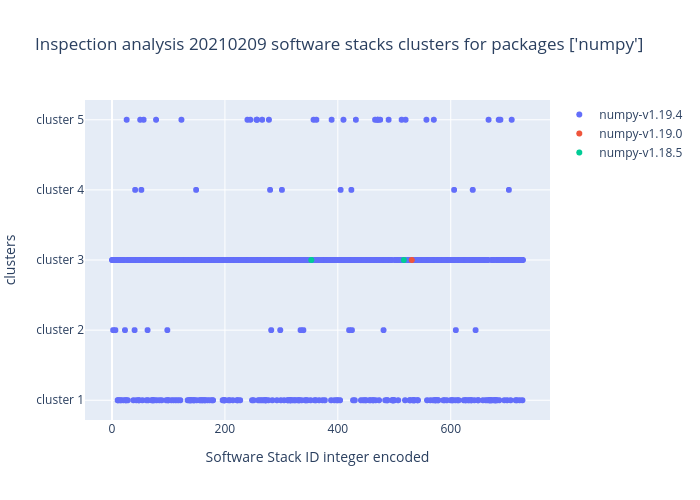

In [12]:
package_names = ['numpy']
title_plot = f"Inspection analysis 20210209 software stacks clusters for packages {package_names}"
fig = AmunInspectionsVisualization.create_packages_versions_2d_plot(
    plot_df=clusters,
    package_names=package_names,
    versions_total_df=versions_total_dataframe,
    title_plot=title_plot
)
from IPython.display import Image
Image(filename=f'./images/{title_plot}.png') 

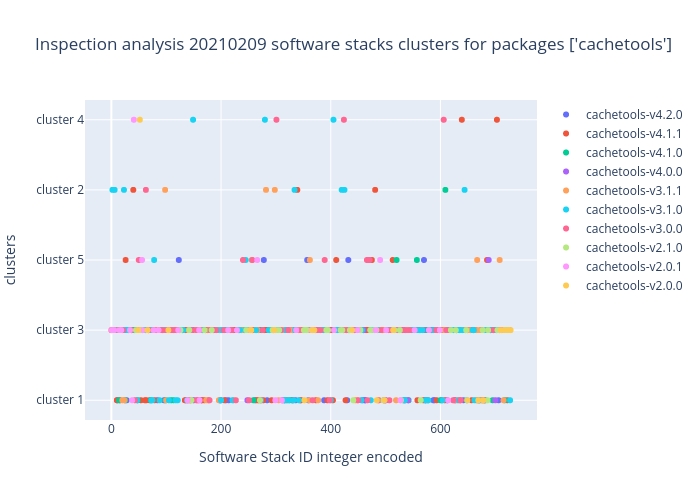

In [12]:
package_names = ['cachetools']
title_plot = f"Inspection analysis 20210209 software stacks clusters for packages {package_names}"
fig = AmunInspectionsVisualization.create_packages_versions_2d_plot(
    plot_df=clusters,
    package_names=package_names,
    versions_total_df=versions_total_dataframe,
    title_plot=title_plot
)
from IPython.display import Image
Image(filename=f'./images/{title_plot}.png') 

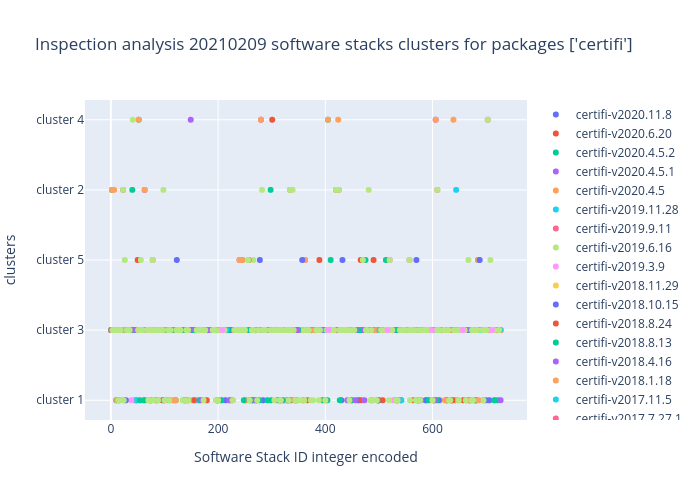

In [13]:
package_names = ['certifi']
title_plot = f"Inspection analysis 20210209 software stacks clusters for packages {package_names}"
fig = AmunInspectionsVisualization.create_packages_versions_2d_plot(
    plot_df=clusters,
    package_names=package_names,
    versions_total_df=versions_total_dataframe,
    title_plot=title_plot
)
from IPython.display import Image
Image(filename=f'./images/{title_plot}.png') 

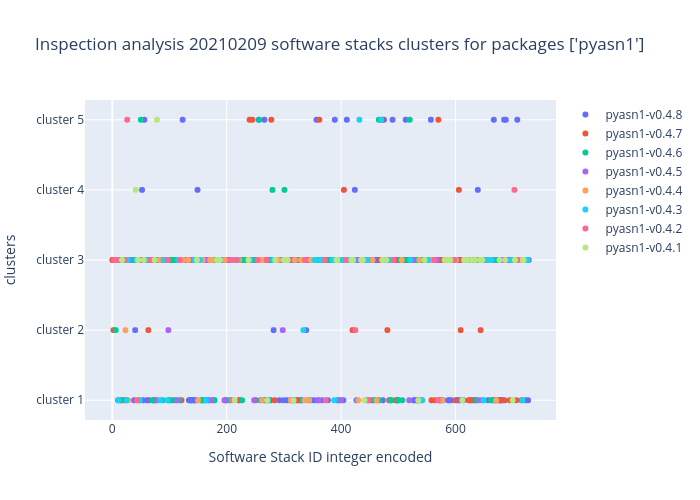

In [14]:
package_names = ['pyasn1']
title_plot = f"Inspection analysis 20210209 software stacks clusters for packages {package_names}"
fig = AmunInspectionsVisualization.create_packages_versions_2d_plot(
    plot_df=clusters,
    package_names=package_names,
    versions_total_df=versions_total_dataframe,
    title_plot=title_plot
)
from IPython.display import Image
Image(filename=f'./images/{title_plot}.png') 

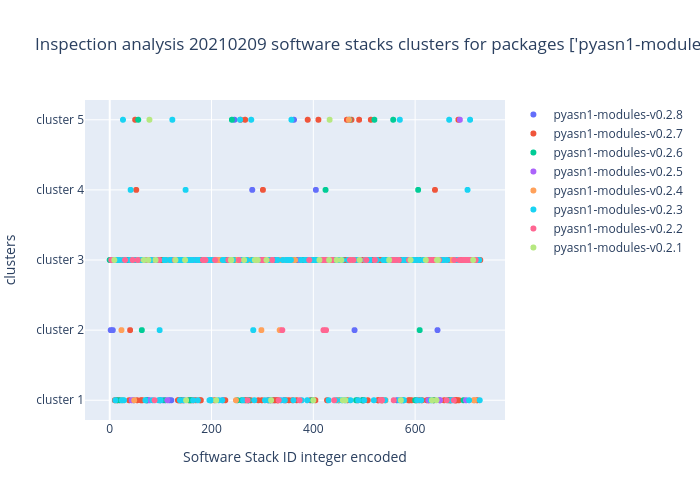

In [15]:
package_names = ['pyasn1-modules']
title_plot = f"Inspection analysis 20210209 software stacks clusters for packages {package_names}"
fig = AmunInspectionsVisualization.create_packages_versions_2d_plot(
    plot_df=clusters,
    package_names=package_names,
    versions_total_df=versions_total_dataframe,
    title_plot=title_plot
)
from IPython.display import Image
Image(filename=f'./images/{title_plot}.png') 

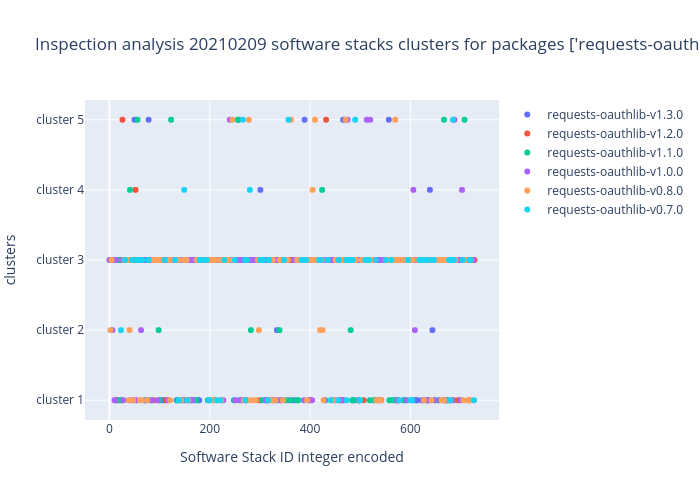

In [16]:
package_names = ['requests-oauthlib']
title_plot = f"Inspection analysis 20210209 software stacks clusters for packages {package_names}"
fig = AmunInspectionsVisualization.create_packages_versions_2d_plot(
    plot_df=clusters,
    package_names=package_names,
    versions_total_df=versions_total_dataframe,
    title_plot=title_plot
)
from IPython.display import Image
Image(filename=f'./images/{title_plot}.png') 

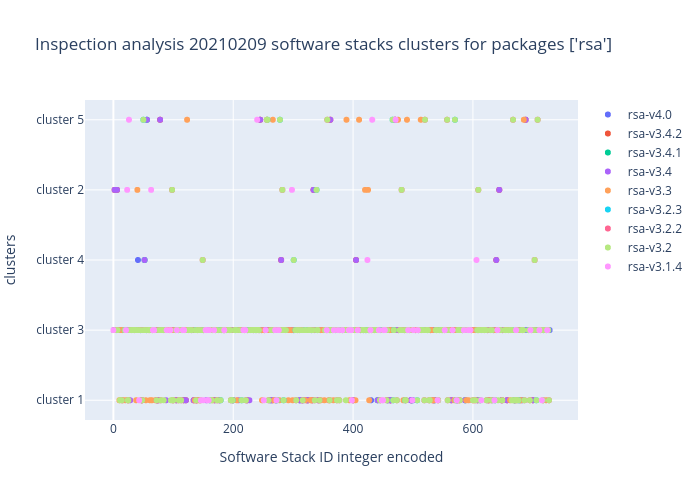

In [17]:
package_names = ['rsa']
title_plot = f"Inspection analysis 20210209 software stacks clusters for packages {package_names}"
fig = AmunInspectionsVisualization.create_packages_versions_2d_plot(
    plot_df=clusters,
    package_names=package_names,
    versions_total_df=versions_total_dataframe,
    title_plot=title_plot
)
from IPython.display import Image
Image(filename=f'./images/{title_plot}.png') 

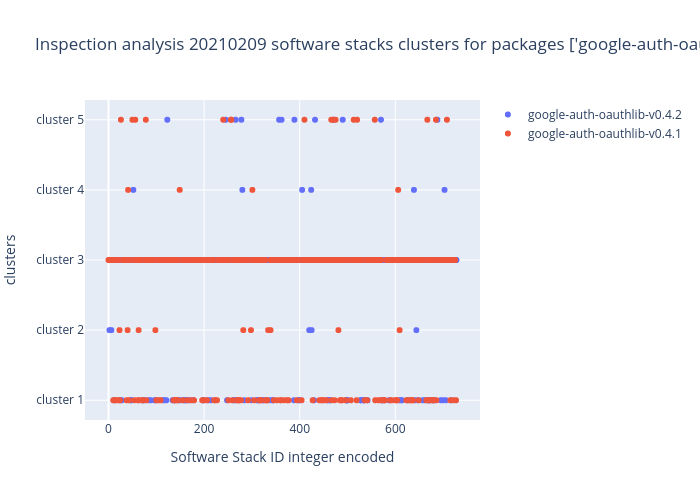

In [18]:
package_names = ['google-auth-oauthlib']
title_plot = f"Inspection analysis 20210209 software stacks clusters for packages {package_names}"
fig = AmunInspectionsVisualization.create_packages_versions_2d_plot(
    plot_df=clusters,
    package_names=package_names,
    versions_total_df=versions_total_dataframe,
    title_plot=title_plot
)
from IPython.display import Image
Image(filename=f'./images/{title_plot}.png') 

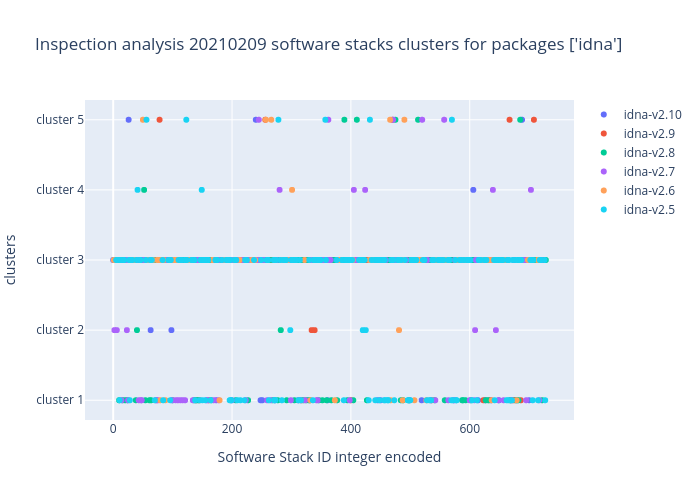

In [19]:
package_names = ['idna']
title_plot = f"Inspection analysis 20210209 software stacks clusters for packages {package_names}"
fig = AmunInspectionsVisualization.create_packages_versions_2d_plot(
    plot_df=clusters,
    package_names=package_names,
    versions_total_df=versions_total_dataframe,
    title_plot=title_plot
)
from IPython.display import Image
Image(filename=f'./images/{title_plot}.png') 

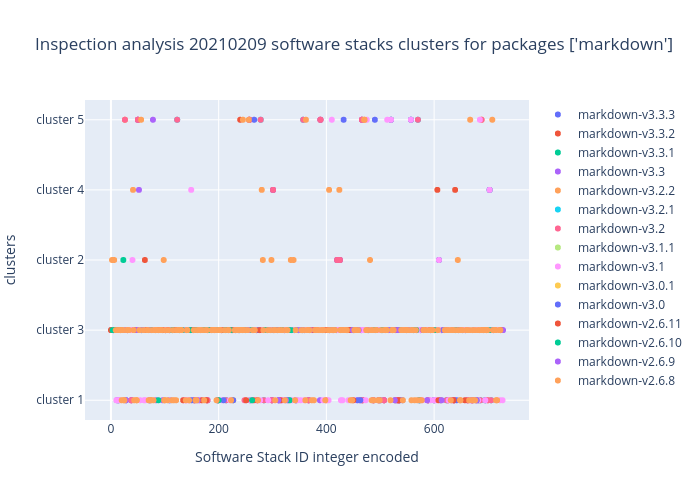

In [20]:
package_names = ['markdown']
title_plot = f"Inspection analysis 20210209 software stacks clusters for packages {package_names}"
fig = AmunInspectionsVisualization.create_packages_versions_2d_plot(
    plot_df=clusters,
    package_names=package_names,
    versions_total_df=versions_total_dataframe,
    title_plot=title_plot
)
from IPython.display import Image
Image(filename=f'./images/{title_plot}.png') 

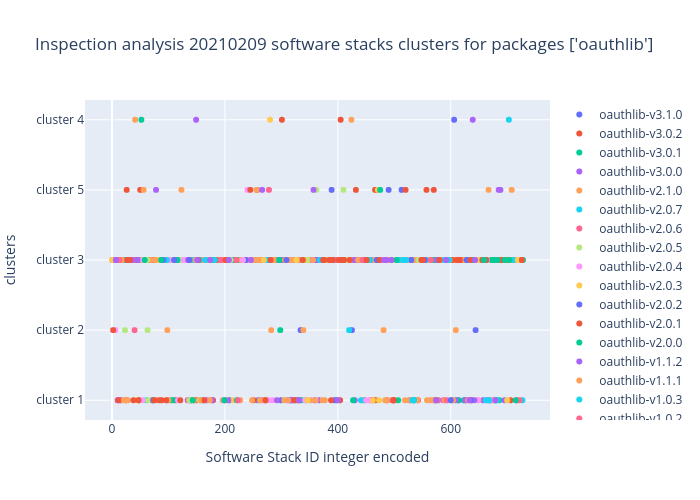

In [21]:
package_names = ['oauthlib']
title_plot = f"Inspection analysis 20210209 software stacks clusters for packages {package_names}"
fig = AmunInspectionsVisualization.create_packages_versions_2d_plot(
    plot_df=clusters,
    package_names=package_names,
    versions_total_df=versions_total_dataframe,
    title_plot=title_plot
)
from IPython.display import Image
Image(filename=f'./images/{title_plot}.png') 

# Analyze inspection builds errors

## Failed inspection builds

In [12]:
failed_builds_inspection_ids = set(inspection_ids_list) - set([r for r in inspections_df['inspection_document_id'].values])

In [13]:
total_failed_builds_inspection_ids = len(failed_builds_inspection_ids)
print(f"Total number of inspection builds is {total_failed_builds_inspection_ids}")

Total number of inspection builds is 72


### Retrieve inspection builds failed logs

In [ ]:
from thoth.storages import InspectionStore
store_class_type = InspectionStore

from pathlib import Path
current_path = Path.cwd()

inspections_build_files = inspection.aggregate_thoth_inspections_results(
    is_local=True,
    store_files=["build_logs"],
    repo_path=current_path.joinpath("inspectionsAnalysis20210209")
)

In [19]:
len(inspections_build_files)

783

In [65]:
failed_inspections_build_sentences = {}
for inspection_id, failed_build_logs in inspections_build_files.items():
    
    sentences = str(failed_build_logs['build_logs']).split("\n")
    if len(sentences) > 5:
        
        if sentences[-2] != 'Push successful':
            failed_inspections_build_sentences[inspection_id] = {"build_logs": sentences[-2:-1]}

print("failed inspection build logs", len(failed_inspections_build_sentences))
failed_build_logs_df = pd.DataFrame(failed_inspections_build_sentences)

for failed_inspection_build_log_sentence in ["".join(looog) for looog in failed_build_logs_df.transpose()['build_logs'].values]:
    print()
    print(failed_inspection_build_log_sentence)

failed inspection build logs 51

Error: received unexpected terminate signal

    Running setup.py install for numpy: still running...

    Running setup.py install for numpy: still running...

Error: received unexpected terminate signal

error: build error: Failed to push image: error copying layers and metadata from "containers-storage:[overlay@/var/lib/containers/storage+/var/run/containers/storage:overlay.imagestore=/var/lib/shared]image-registry.openshift-image-registry.svc:5000/thoth-amun-inspection-stage/inspection-tf-dm-tf24-8a031107:latest" to "docker://image-registry.openshift-image-registry.svc:5000/thoth-amun-inspection-stage/inspection-tf-dm-tf24-8a031107:latest": Error writing manifest: Error uploading manifest latest to image-registry.openshift-image-registry.svc:5000/thoth-amun-inspection-stage/inspection-tf-dm-tf24-8a031107: manifest blob unknown: blob unknown to registry

Error: received unexpected terminate signal

Error: received unexpected terminate signal

error: 

In [56]:
proces1 = ["".join(looog) for looog in failed_build_logs_df.transpose()['build_logs'].values]
timeout_error = 0
push_error = 0
other_error = 0

for p in proces1:
    
    if 'Error: received unexpected terminate signal' in p:
        timeout_error += 1
    elif 'error: build error: Failed to push image' in str(p):
        push_error += 1
    else:
        print("Other error \n", p)
        other_error += 1
        
print(f"Number of timeout error is {timeout_error}")
print(f"Number of push error is {push_error}")
print(f"Number of other error is {other_error}")

Other error 
     Running setup.py install for numpy: still running...
Other error 
     Running setup.py install for numpy: still running...
Other error 
     Running setup.py install for numpy: still running...
Other error 
     Running setup.py install for numpy: still running...
Other error 
     Running setup.py install for numpy: still running...
Number of timeout error is 19
Number of push error is 27
Number of other error is 5


## Failed inspection runs

In [57]:
failed_inspections_df = inspection.create_inspections_dataframe(
    processed_inspection_runs=failed_inspection_runs,
)

In [58]:
failed_inspections_df

""


## Conclusions

After initial analysis of this dataset, `801` inspections have been identified. These inspections have been created for different stack combinations of TensorFlow 2.4.0 on ubi8 with python38.

The following conclusions have been found at the moment:

**inspection builds failed**

- 51 inspections failed during builds identified.

After further analysis of this failed builds, the following causes have been identified:

** CASE 1: 27 are due to push error with the following logs:

```
error: build error: Failed to push image: error copying layers and metadata from "containers-storage:[overlay@/var/lib/containers/storage+/var/run/containers/storage:overlay.imagestore=/var/lib/shared]image-registry.openshift-image-registry.svc:5000/thoth-amun-inspection-stage/inspection-tf-dm-tf24-ID:latest" to "docker://image-registry.openshift-image-registry.svc:5000/thoth-amun-inspection-stage/inspection-tf-dm-tf24-ID:latest": Error writing manifest: Error uploading manifest latest to image-registry.openshift-image-registry.svc:5000/thoth-amun-inspection-stage/inspection-tf-dm-tf24-ID: manifest blob unknown: blob unknown to registry
```

** CASE 2: 19 appear to have been caused by some external source (maybe timeout?):

```
Error: received unexpected terminate signal
```

** CASE 3: 5 cases can be associated to CASE 2 after checking similar errors.


**inspection with results**

Analyzing the other 729 inspections:

** 0 inspections runs failed identified. No differences worth mentioning.

It appears this dataset does not contain failures that we can investigate to provide a new recommendation to users.

If no further investigations are requested, I would proceed cleaning the notebook, prepare the dataset and publish everything in this repo.


**inspection with results: performance**

New plots to check specific versions available in different clusters have been added for a deeper understanding on the software stacks differences identified in the three main clusters.